Original code from:
https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_googlenet.ipynb

# Get output probabilities

In [ ]:
%%capture
import torch
import torchvision.models as models
from torchvision import transforms
import copy
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os 

# model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
model = models.googlenet(pretrained=True)  #w/o arg, this will not pretrain it
# model = models.vgg16(pretrained=True)

model.eval() #set model in eval mode: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch

# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
from google.colab import files
files.upload()

In [ ]:
def get_output(model, input_image):
    # input_image = Image.open(input)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    return output
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # print(output[0])  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.

def output_probs(model, input_image):
    output = get_output(model, input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

def get_top_categories(probabilities, categories):
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())




---

# Compare activations for different levels of abstraction



Now try comparing:
tiger shark 1 vs tiger shark 2 (both tiger sharks)

tiger shark vs great white shark (both sharks)

shark vs dog (both animals)

dog vs car (both have 4 "legs")

shark vs car (unrelated, to a human?)

image w/ only dog vs image w/ dog + cat

face vs face w/o nose



---



# Try Jaccard Similarity to compare activation similarities between layers

Manually upload kaggle.json before running code below


In [ ]:
%%capture
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals
! unzip animal-image-dataset-90-different-animals.zip

data_dir = 'animals/animals'
f = open("name of the animals.txt", "r")
animals_list = f.readlines()
animals_list = [x.replace('\n','') for x in animals_list]

x --> y: function x calls function y

get_multipleLayer_scores --> 

get_weighted_scores --> 

get_categories_scores --> 

get_jaccard_sim --> 

(get_sorted_neurons, jaccard_similarity) --> 

get_sorted_neurons --> 

get_activations

In [ ]:
import copy

top_neurons_dict = {} # (image, layer) : top X neurons

# need to create new fn b/c activation hook set before sending image thru model
def get_activations(input_image, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    output = model(input_batch)
    return activation.copy()  #else will return the same actvs of model
    
# flatten activation tensor and sort from lowest to highest
def get_sorted_neurons(input_image, layer, filename):
    actv_layer = get_activations(input_image, layer)
    flat_layer = torch.flatten(actv_layer[layer])
    sorted, indices = torch.sort(flat_layer)
    top_neurons_dict[(filename, layer)] = indices.tolist()
    return indices.tolist()

# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

# a score for a pair of images
def get_jaccard_sim(image1, image2, layer, f, f_2, topPerc):
    if (f, layer) in top_neurons_dict:
        sorted_neurons_1 = top_neurons_dict[(f, layer)]
    else:
        sorted_neurons_1 = get_sorted_neurons(image1, layer, f)
    if (f_2, layer) in top_neurons_dict:
        sorted_neurons_2 = top_neurons_dict[(f_2, layer)]
    else:
        sorted_neurons_2 = get_sorted_neurons(image2, layer, f_2)
    topNum = round(len(sorted_neurons_1)*topPerc)
    return jaccard_similarity(sorted_neurons_1[-topNum:], sorted_neurons_2[-topNum:])

# returns: for the score of every pair of images, bin them into frequencies
def get_categories_scores(sample1_dir, sample2_dir, layer, topPerc, numSamp):
    sample1 = os.listdir(sample1_dir)[0:numSamp]
    sample2 = os.listdir(sample2_dir)[0:numSamp]
    categories_scores = []  # score for every pair of images
    for filename in sample1:
        f = os.path.join(sample1_dir, filename)
        for filename_2 in sample2:
            f_2 = os.path.join(sample2_dir, filename_2)
            if f != f_2:
                input_image_1 = Image.open(f)
                input_image_2 = Image.open(f_2)
                #sim: a score for a pair of images
                sim = get_jaccard_sim(input_image_1, input_image_2, layer, f, f_2, topPerc)
                categories_scores.append(sim)
                if len(categories_scores) % 10 == 0:
                    print(len(categories_scores))
    counts, bins, bars = plt.hist(categories_scores)
    return counts, bins, bars

# get dot product of frequency and score range
def get_weighted_scores(sample1_dir, sample2_dir, layer, topPerc, numSamp):
    counts,bins,bars = get_categories_scores(sample1_dir, sample2_dir, layer, topPerc, numSamp)
    return sum([x*y for x,y in zip(counts,bins)])

In [ ]:
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# too many branches, so just get the converged branch points
# '' is first layer, the input, so disregard it
layers = [x for x in layers if '.' not in x and x != '']  

In [ ]:
# get a weighted score for every (category_1, category_2, layer)
def get_multipleLayer_scores(category_1, category_2, topPerc, layers, numSamp):
    pair_scores = {}

    # for each (image, layer), calc and store actvs once
    # create class or global var dict of (image, layer) : topPerc neurons

    for layer in layers:
        if layer == '':
            continue
        pair_scores[layer] = get_weighted_scores(category_1, category_2, layer, topPerc, numSamp)
    return pair_scores

In [ ]:
%%capture
antelope_dir = data_dir + '/antelope'
badger_dir = data_dir + '/badger'
bat_dir = data_dir + '/bat'
topPerc = 0.01
numSamp = 10

badger_badger_scores = get_multipleLayer_scores(badger_dir, badger_dir, topPerc, layers, numSamp)
bat_badger_scores = get_multipleLayer_scores(bat_dir, badger_dir, topPerc, layers, numSamp)

In [ ]:
# top 1%. normalize by # of pairs

badger_badger_scores_plot = []
bat_badger_scores_plot = []

for layer in layers:
    if layer == '':
        continue
    print(layer)
    score_1 = round(badger_badger_scores[layer] / 90, 2)
    score_2 = round(bat_badger_scores[layer] / 100, 2)
    badger_badger_scores_plot.append(score_1)
    bat_badger_scores_plot.append(score_2)
    print('    badger_badger_scores: ', score_1)
    print('    bat_badger_scores:   ', score_2)
    if score_2 != 0:
        print('    ratio:   ', round(score_1 / score_2, 2))

In [ ]:
plt.plot(range(len(badger_badger_scores_plot)), badger_badger_scores_plot, 
         label = 'badger_badger')
plt.plot(range(len(bat_badger_scores_plot)), bat_badger_scores_plot, 
         label = 'bat_badger')
plt.legend()

In [ ]:
%%capture
antelope_badger_scores = get_multipleLayer_scores(antelope_dir, badger_dir, topPerc, layers, numSamp)
antelope_badger_scores_plot = []
for layer in layers:
    if layer == '':
        continue
    score = round(antelope_badger_scores[layer] / 100, 2)
    antelope_badger_scores_plot.append(score)

In [ ]:
%%capture
antelope_bat_scores = get_multipleLayer_scores(antelope_dir, bat_dir, topPerc, layers, numSamp)
antelope_bat_scores_plot = []
for layer in layers:
    score = round(antelope_bat_scores[layer] / 100, 2)
    antelope_bat_scores_plot.append(score)

In [ ]:
%%capture
bat_bat_scores = get_multipleLayer_scores(bat_dir, bat_dir, topPerc, layers, numSamp)
bat_bat_scores_plot = []
for layer in layers:
    score = round(bat_bat_scores[layer] / 90, 2)
    bat_bat_scores_plot.append(score)

In [ ]:
%%capture
antelope_antelope_scores = get_multipleLayer_scores(antelope_dir, antelope_dir, topPerc, layers, numSamp)
antelope_antelope_scores_plot = []
for layer in layers:
    score = round(antelope_antelope_scores[layer] / 90, 2)
    antelope_antelope_scores_plot.append(score)

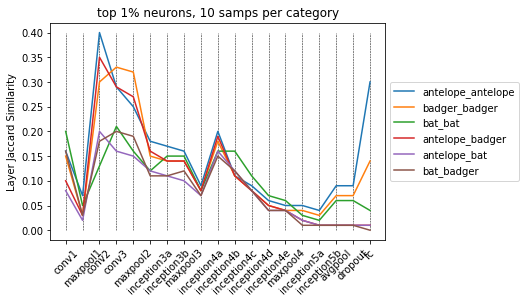

In [ ]:
plt.plot(layers, antelope_antelope_scores_plot, 
         label = 'antelope_antelope')
plt.plot(layers, badger_badger_scores_plot, 
         label = 'badger_badger')
plt.plot(layers, bat_bat_scores_plot, 
         label = 'bat_bat')

plt.plot(layers, antelope_badger_scores_plot, 
         label = 'antelope_badger')
plt.plot(layers, antelope_bat_scores_plot, 
         label = 'antelope_bat')
plt.plot(layers, bat_badger_scores_plot, 
         label = 'bat_badger')

plt.vlines(layers, 0, [0.4]*len(layers), linestyle="dashed", linewidth= 0.5)

ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.title('top 1% neurons, 10 samps per category')
plt.ylabel('Layer Jaccard Similarity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Overall, it's very hard to tell the difference using this method. It's not until Inception5a do we see differences in the plot; before that, the between-categories sometimes score higher on similarity than within-categories.


---

Now try 20 samples

In [ ]:
%%capture
top_neurons_dict = {}  #MUST reset this for every diff topPerc, numSamp

topPerc = 0.01
numSamp = 20
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# too many branches, so just get the converged branch points
# '' is first layer, the input, so disregard it
layers = [x for x in layers if '.' not in x and x != '' and 'pool' not in x \
          and 'drop' not in x and 'fc' not in x]  

to_plot = {}
classes = ['antelope', 'badger', 'bat']

for class_1 in classes:
    for class_2 in classes:
        lineName = class_1 + '-' + class_2
        lineNameRev = class_2 + '-' + class_1
        if lineName in to_plot or lineNameRev in to_plot:
            continue
        dir_1 = data_dir + '/' + class_1
        dir_2 = data_dir + '/' + class_2
        pair_jaccard_scores = get_multipleLayer_scores(dir_1, dir_2, topPerc, layers, numSamp)
        pair_scores_plot = []
        for layer in layers:
            if class_1 == class_2:
                score = round(pair_jaccard_scores[layer] / (numSamp**2 - numSamp), 2)
            else:
                score = round(pair_jaccard_scores[layer] / numSamp**2, 2)
            pair_scores_plot.append(score)
        to_plot[class_1 + '-' + class_2] = pair_scores_plot.copy()

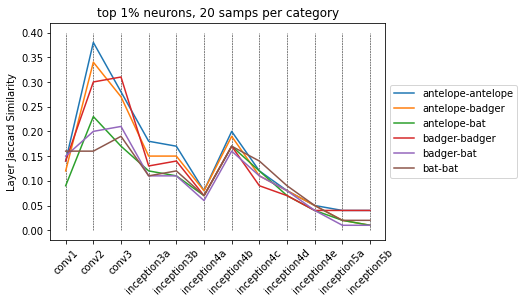

In [ ]:
plt.clf()

already_plotted = []
for class_1 in classes:
    for class_2 in classes:
        lineName = class_1 + '-' + class_2
        if lineName not in to_plot:
            lineName = class_2 + '-' + class_1
        if lineName not in already_plotted:
            plt.plot(layers, to_plot[lineName], 
            label = lineName)
            already_plotted.append(lineName)
        
plt.vlines(layers, 0, [0.4]*len(layers), linestyle="dashed", linewidth= 0.5)

ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.title('top 1% neurons, 20 samps per category')
plt.ylabel('Layer Jaccard Similarity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Again, at 4e, there is some difference, but not much. Bat-bat especially is not that distinguished from the between-category scores.

---

But WHICH neurons are similar? If we look at them, we can check their feature viz on Microscope. 

Also, perhaps these are similar because they're animals, despite there not being an animal class (the NN learns to separately purely based on visual differences, not conceptual, so it may think ladybug and 'red ball' are more similar than ladybug and butterfly). Try to compare between visually similar and visually dissimilar classes.

The aim is to first find if there is some sort of discriminatory pattern recognizing hierarchies of visually-distinguished classes. This can also be done by examining the latent spaces (which are just activation spaces, so that's also based on activations).



---

After finding which neurons are different, look at those specific neurons.

How to summarize per neuron (detector), not per output?

Histogram to find number of neurons that fire at certain range: does not identify WHICH neurons fire

Try seeing if middle ranked activations also works